<a href="https://colab.research.google.com/github/deep-l3arn3r/tutorials/blob/main/torch_3_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import inspect
from torchvision.datasets import MNIST
from torchvision import transforms

In [4]:
inspect.signature(MNIST)

<Signature (root: str, train: bool = True, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False) -> None>

In [5]:
train_data = MNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
test_data = MNIST(root="data", train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 105584013.07it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 18320582.85it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28258231.82it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15783370.98it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [6]:
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [7]:
X_train, y_train = train_data.data.unsqueeze(dim=1), train_data.targets
X_test, y_test = test_data.data.unsqueeze(dim=1), test_data.targets

Text(0.5, 1.0, '0')

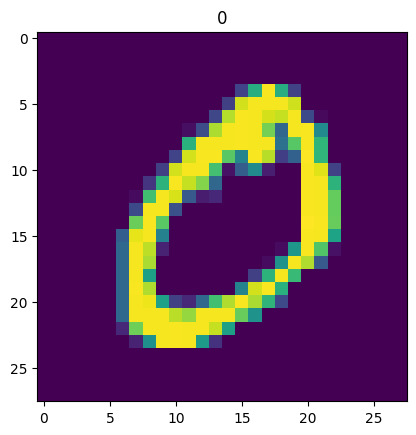

In [8]:
import matplotlib.pyplot as plt
image, label = X_train[1], y_train[1]
plt.imshow(image.squeeze())
plt.title(label.item())

***DataLoaders***

In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_data_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_data_loader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

len(train_data_loader), len(test_data_loader)

(1875, 313)

In [10]:
from torch import nn

In [11]:
X_train[0].shape

torch.Size([1, 28, 28])

In [19]:
class MNISTModelV0(nn.Module):
  def __init__(self, input_shape, hidden_shape, output_shape):
    super().__init__()

    self.block1 = nn.Sequential(
      nn.Conv2d(input_shape, hidden_shape, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(hidden_shape, hidden_shape, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
    )

    self.block2 = nn.Sequential(
      nn.Conv2d(hidden_shape, hidden_shape, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(hidden_shape, hidden_shape, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_shape*7*7, out_features=output_shape),
    )

  def forward(self, x):
    # print(x.shape)
    x = self.block1(x)

    # print(x.shape)
    x = self.block2(x)

    # print(x.shape)
    x = self.classifier(x)

    return x


In [20]:
model2 = MNISTModelV0(input_shape=1, hidden_shape=10, output_shape=10)
model2

MNISTModelV0(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [21]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [22]:
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss() #
optimizer = torch.optim.SGD(params=model2.parameters(), lr=0.1)

In [23]:
def the_step(model, train_loader, test_loader, loss_fn, accuracy_fn, optim):

  train_loss, train_accuracy = 0, 0

  for batch, (X, y) in enumerate(train_loader):

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    train_accuracy += accuracy_fn(y, y_pred.argmax(dim=1))

    optim.zero_grad()

    loss.backward()

    optim.step()

  train_loss /= len(train_loader)
  train_accuracy /= len(train_loader)

  test_loss, test_accuracy = 0, 0

  model.eval()

  with torch.inference_mode():

    for batch, (X, y) in enumerate(test_loader):

      y_pred = model(X)

      loss = loss_fn(y_pred, y)
      test_loss += loss.item()
      test_accuracy += accuracy_fn(y, y_pred.argmax(dim=1))

    test_loss /= len(test_loader)
    test_accuracy /= len(test_loader)

    return {'Train_loss':train_loss,
            'Train_acc':train_accuracy,
            'Test_loss':test_loss,
            'Test_acc':test_accuracy}

In [25]:
from tqdm import tqdm

In [26]:
EPOCHS = 10
values = []

for epoch in tqdm(range(EPOCHS)):
  details = the_step(model2, train_data_loader, test_data_loader, loss_fn, accuracy_fn, optimizer)
  values.append(details)


100%|██████████| 10/10 [09:53<00:00, 59.33s/it]


In [30]:
final_model = model2

In [44]:
final_model.eval()
with torch.inference_mode():
  X_test = X_test.to(dtype=torch.float32)
  y_pred_test = model2(X_test)
  y_pred_test = y_pred_test.argmax(dim=1)

y_pred_test

tensor([7, 2, 1,  ..., 4, 5, 6])

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [45]:
accuracy_fn(y_test, y_pred_test)

98.38

<Axes: >

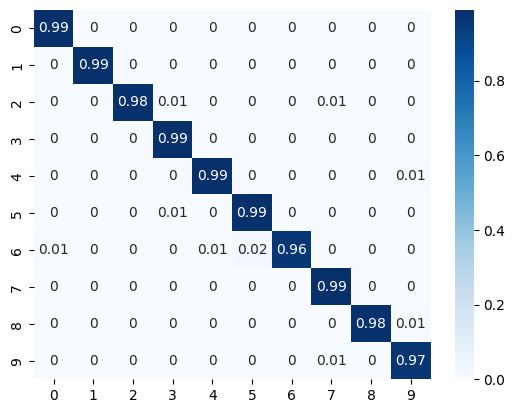

In [56]:
import numpy as np
cm = np.round(confusion_matrix(y_test, y_pred_test, normalize='true'),2)
sns.heatmap(cm, annot=True, cmap="Blues",xticklabels=list(range(10)), yticklabels=list(range(10)))